# dTEC test program

Since I am having trouble trying to make the program that computes medTEC I will try to run this program step by step in order to find what is wrong and try to correct the program until it works.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
import pandas as pd
import seaborn as sns

In [2]:
station = "boav"
datafiles = glob.glob("./data/2019-06-22/set5/previous/{}*.Std".format(station))

In [3]:
outtab = Table(names=('FileID', 'time', 'TEC', 'sigma_TEC'))
for j,f in enumerate(datafiles):
    tab = Table.read(f, format="ascii")
    time = tab["col1"]
    TEC = tab["col2"]
    s_TEC = tab["col3"]
    for i, tec in enumerate(TEC):
        if tec == "-":
            guantec = np.nan
        else: 
            guantec =float(tec)
        if s_TEC[i] == "-":
            s_guantec = np.nan
        else:
            s_guantec =float(s_TEC[i])
        outtab.add_row([int(j+1), time[i], guantec, s_guantec])
outtab.write("test_table.tab", format="ascii", overwrite=True)

# Second part: Open, plot and compute median from test_table.tab

In [4]:
import statistics as stats

(0.0, 24.0)

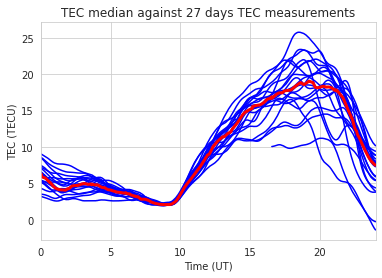

In [16]:
sns.set_style("whitegrid")
tabular = Table.read("test_table.tab", format="ascii")
Time = np.unique(tabular["time"])
ID = np.unique(tabular["FileID"])
TEC_median = np.zeros_like(Time)
sTEC_m = np.zeros_like(Time)
for i,T in enumerate(Time):
    time_mask = tabular["time"] == T
    m_time = tabular["time"][time_mask]
    m_TEC = tabular["TEC"][time_mask]
#    m_sTEC = np.isfinite(tabular["sigma_TEC"][time_mask])
    TEC_median[i] = stats.median(m_TEC)
#    sTEC_m[i] = max(m_sTEC) 
for j in ID:
    ID_mask = tabular["FileID"] == j
    t = tabular["time"][ID_mask]
    ttec = tabular["TEC"][ID_mask]
#    stec = np.isfinite(tabular["sigma_TEC"][ID_mask])
    plt.plot(t, ttec, "b")
#    plt.fill_between(t, ttec-stec, ttec+stec, "b", alpha=0.1)
plt.plot(Time, TEC_median, "r", lw=3)
#plt.fill_between(Time, TEC_median-sTEC_m, TEC_median+sTEC_m, "r", alpha=0.3)
plt.xlabel("Time (UT)")
plt.ylabel("TEC (TECU)")
plt.title("TEC median against 27 days TEC measurements")
plt.xlim(0, 24.)

## Compute dTEC and W index

According to Shaden's thesis, the dTEC is defined as [(Gulyaeba & Stanislawska, 2008)](https://angeo.copernicus.org/articles/26/2645/2008/):
\begin{equation}
dTEC = \log_{10}{\frac{TEC}{medTEC}}
\end{equation}

Where $TEC$ is the Average TEC in a certain day, while $medTEC$ is the median of the TEC measurements of the previous 27 days. 

In the other hand, based in the value of dTEC we can define a W index as follows:


|DTEC | W Index | Ionospheric description|
|-----|---------|------------------------|
|$$|dTEC| > 0.301$$  | $\pm 4$ | Intense ionospheric storm |
|$$ 0.155 < |dTEC| \le 0.301 $$|$\pm 3$|Moderate ionospheric storm|
|$$ 0.046 < |dTEC| \le 0.155 $$|$\pm 2$|Moderate disturbance|
|$$ 0 < |dTEC| \le 0.046 $$|$\pm 1$|Quiet state|
|$$ dTEC =0 $$|+0|Reference quiet stage|

Load and plot TEC data and compare with median

Text(0.5, 1.0, 'Event day average TEC against TEC median')

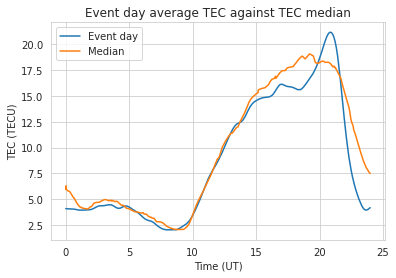

In [6]:
T_data = Table.read("./data/2019-06-22/set5/boav173-2019-06-22.Std", format="ascii")
T_ime = T_data["col1"]
T_EC = T_data["col2"]
plt.plot(T_ime, T_EC, label="Event day")
plt.plot(Time, TEC_median, label="Median")
plt.legend()
plt.xlabel("Time (UT)")
plt.ylabel("TEC (TECU)")
plt.title("Event day average TEC against TEC median")

Estimation of dTEC and W index

Text(0.5, 1.0, 'dTEC and W index for event day')

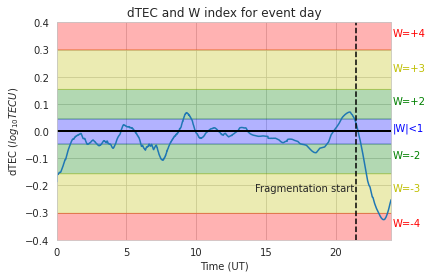

In [7]:
dTEC = np.log10(T_EC/TEC_median)
f_time = 21+25/60. + 48./3600.
plt.plot(T_ime, dTEC)
plt.axhline(0, c="k", lw=2)
plt.axvline(f_time, ls="--", c="k")
plt.fill_between(T_ime, -0.046, 0.046, color="b", alpha=0.3)
plt.fill_between(T_ime, 0.046, 0.155, color="g", alpha=0.3)
plt.fill_between(T_ime, -0.046, -0.155, color="g", alpha=0.3)
plt.fill_between(T_ime, 0.155, 0.301, color="y", alpha=0.3)
plt.fill_between(T_ime, -0.155, -0.301, color="y", alpha=0.3)
plt.fill_between(T_ime, 0.301, 0.5, color="r", alpha=0.3)
plt.fill_between(T_ime, -0.301, -0.5, color="r", alpha=0.3)
plt.text(24.1, 0.35, "W=+4", color="r")
plt.text(24.1, -0.35, "W=-4", color="r")
plt.text(24.1, 0.22, "W=+3", color="y")
plt.text(24.1, -0.22, "W=-3", color="y")
plt.text(24.1, 0.1, "W=+2", color="g")
plt.text(24.1, -0.1, "W=-2", color="g")
plt.text(24.1, 0., r"|W|<1", color="b")
plt.text(14.2, -0.22, "Fragmentation start")
plt.xlim(0, 24.)
plt.ylim(-0.4, 0.4)
plt.xlabel("Time (UT)")
plt.ylabel(r"dTEC $(log_{10}{TECU})$")
plt.title("dTEC and W index for event day")

After fragmentation, we can see that W index drops to -4, which is uncertain to atributte or not to the bolide perturbation, we need to compare this result with other stations. Now it is time to implement this work for all stations.